# Finding Hidden Local Patterns  
With semiconductor and opto-electronic device performances rapidly increasing, the specifications for related manufacturing processes are tightening at rapid rates. Manufacturing equipment used in these processes must stay ahead of pace to maintain roadmap targets. That means that improvements to current equipment by themselves are insufficient and solutions for the N+1 or farther generations must be worked on simultaneously.  
  
Typical semi- and opto-electronic device fabrication involves anywhere from dozens to over a thousand thin film deposition, etch, and patterning steps on semiconductor wafers or other substrates. The final device yield is highly dependent on the spatial uniformity of individual thin film layers across the substrate. These non-uniformities are typically caused by limitations of hardware or stability of process conditions. Thus, understanding the unwanted spatial variation of critical thin film properties, such as thickness, conductivity, or optical properties, is key to designing better manufacturing hardware and increasing final device yield.   
  
Non-uniformity of thin films on semiconductor wafers is undergoing a dramatic improvement from >30% in the early 90's to 10-15% in early 2000's, and now fast approaching <1% targets. The difficulty of achieving such improvements grows rapidly from level to level. While going from 30% to 20% may have taken only a few years, going from 15% to 5% took nearly a decade for some processes. One can also easily imagine that since it is hard to even find a <1% variation pattern caused by hardware limitations in the data that has overall variation of 10-15% all improvements were sequential. However, as discussed above, waiting to find the hidden patterns is no longer an option.

Early on non-uniformities of many processes were typically dominated by long-range spatial trends. As manufacturing equipment became more sophisticated and the long-range issues were being addressed, the importance of local non-uniformities started to grow. However, while the understanding that the next big non-uniformity problem will be caused by local patterns was there, the ability to find these patterns was still limited.

This notebook describes a real life use case of a search for hidden local patterns in the uniformity of thin films deposited by chemical vapor deposition (for confidentiality purposes, real thin film uniformity data was replaced with qualitatively similar trends and real hidden local pattern was replaced by a smiley kitty face). We discuss an approach to finding hidden local spatial patterns in the overall long-range trends by performing **Local Deviation Transformation (LDT)**. LDT transforms the data by replacing input values at each spatial coordinate with the deviation of those values from the weighted average of the surrounding neighborhood. By limiting the size of the neighborhood and minimizing the contributions of farther neighbors the effects of the long-range trends are minimized and local patterns emerge.

**Requirements**: Python 3.6+, numpy, pandas, sklearn, matplotlib

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
%matplotlib inline

## Import and Visualize Data  
We import data from previously generated sample data files. The code for generating the data can be found in the **2D Polar Maps With Hidden Patterns.ipynb** notebook. Files contain data with concave, convex, and donut shaped long-range trends with and without hidden patterns. The overall patterns in each set contain ~0.5% of random noise, <2% contribution from hidden patterns (if present), and the remainder coming from long-range radial trends.

In [2]:
# import
data_concave = pd.read_csv('data/concave.csv')
data_concave_nohidden = pd.read_csv('data/concave_nohidden.csv')
data_convex = pd.read_csv('data/convex.csv')
data_convex_nohidden = pd.read_csv('data/convex_nohidden.csv')
data_donut = pd.read_csv('data/donut.csv')
data_donut_nohidden = pd.read_csv('data/donut_nohidden.csv')

Let's examine what our data sets look like:

In [3]:
# exammine data frame
data_concave.head()

,X,Y,R,Theta,Value
0,0.00,0.00,0.00,0.0,0.001632
1,12.25,0.00,12.25,0.0,0.006301
2,8.66,8.66,12.25,45.0,0.004657
3,0.00,12.25,12.25,90.0,-0.017465
4,-8.66,8.66,12.25,135.0,0.002250


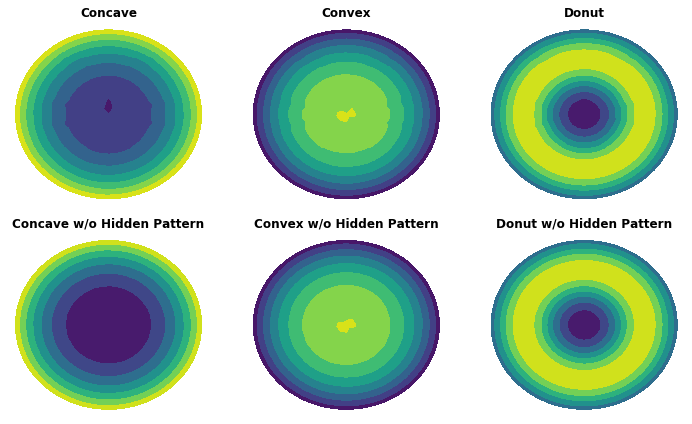

In [39]:
# Contour plots
fig1 = plt.figure(figsize=(10, 6))
fig1.subplots_adjust(top=0.8)

# arrange plots
ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3= plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))
ax6 = plt.subplot2grid((2, 3), (1, 2))


# set titles
ax1.set_title('Concave', fontweight='bold')
ax2.set_title('Convex', fontweight='bold')
ax3.set_title('Donut', fontweight='bold')
ax4.set_title('Concave w/o Hidden Pattern', fontweight='bold')
ax5.set_title('Convex w/o Hidden Pattern', fontweight='bold')
ax6.set_title('Donut w/o Hidden Pattern', fontweight='bold')

# rescale axes
for ax in fig1.axes:
    ax.set_xlim([-160, 160])
    ax.set_ylim([-160, 160])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set(frame_on=False)

# plot data
ax1.tricontourf(data_concave.X, data_concave.Y, data_concave.Value)
ax2.tricontourf(data_convex.X, data_convex.Y, data_convex.Value)
ax3.tricontourf(data_donut.X, data_donut.Y, data_donut.Value)
ax4.tricontourf(data_concave_nohidden.X, data_concave_nohidden.Y, data_concave_nohidden.Value)
ax5.tricontourf(data_convex_nohidden.X, data_convex_nohidden.Y, data_convex_nohidden.Value)
ax6.tricontourf(data_donut_nohidden.X, data_donut_nohidden.Y, data_donut_nohidden.Value)

# fix layout
plt.tight_layout()

As can be seen from the figure above, the differences between the data sets with and without hidden patterns are nearly negligible and we cannot clearly discern any patterns beyond long-range concave, convex, and donut trends on the 2D contour plots.

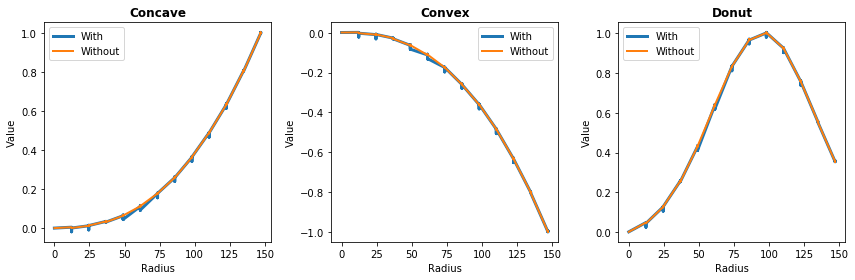

In [19]:
# Radial plots
fig2 = plt.figure(figsize=(12, 4))
fig2.subplots_adjust(top=0.8)

# arrange plots
ax7 = plt.subplot2grid((1, 3), (0, 0))
ax8 = plt.subplot2grid((1, 3), (0, 1))
ax9= plt.subplot2grid((1, 3), (0, 2))

# set titles
ax7.set_title('Concave', fontweight='bold')
ax8.set_title('Convex', fontweight='bold')
ax9.set_title('Donut', fontweight='bold')

for ax in fig2.axes:
    ax.set_xlabel('Radius')
    ax.set_ylabel('Value')


# plot data
ax7.plot(data_concave.R, data_concave.Value, linewidth=3)
ax7.plot(data_concave_nohidden.R, data_concave_nohidden.Value, linewidth=2)
ax8.plot(data_convex.R, data_convex.Value, linewidth=3)
ax8.plot(data_convex_nohidden.R, data_convex_nohidden.Value, linewidth=2)
ax9.plot(data_donut.R, data_donut.Value, linewidth=3)
ax9.plot(data_donut_nohidden.R, data_donut_nohidden.Value, linewidth=2)

# add legend and increase line width
for ax in [ax7, ax8, ax9]:
    ax.legend(['With', 'Without'])

# fix layout
plt.tight_layout()

We have slightly better luck finding small perturbations (remember the <2% hidden pattern?) in the data on the radial profile plots above, but we cannot easily tell the 2D locations or say anything at all about the 2D shape of these perturbations. Thus, we would not be able to link these spatial non-uniformities to specific hardware features causing them in the thin film deposition tool.  
  
So, how do we go about finding these features?
  
We can minimize the importance of the overwhelming long-range trends in the data, by examining only the variations in the small local subsets -- the neighborhoods. By calculating how much a value differs at each point from its surrounding points, limiting the radius of the neighborhood, and scaling the importance of the more distant neighbors, we can zoom in on local patterns in the otherwise long-range trends. The transformation of value at point $V_{i}\left(x_{i},y_{i}\right)$ can be mathematically expressed as follows:  
  
$V_i^{LDT}=V_i-V_i^{neighborhood\ weighted\ ave}$
  
$V_i^{neighborhood\ weighted\ ave}=\ \frac{\sum_{j}{w_j\ V_j}}{\sum_{j} w_j}$  
  
where neighborhood $j$ with radius $R_{local}$ is $j\ni distance\left(i,j\right)\ \le\ R_{local}$ and inverse distance weights for neighborhood points are $w_j=\frac{1}{{d\left(i,\ j\right)}^p}$, 
where $p$ is the power parameter in the Shepard's method of inverse distance weighting [1].  
  
Using these equations lets perform the LDT transformations of our data sets and see what comes out. In parallel we also perform transformations on the data that does not contain hidden patterns for comparison.

In [20]:
def shepards_weights(distances, power=0):
    """Returns inverse distance weights using Shepard's method for input distances
       wi = 1 / (d0, di) ** power: for d != 0, otherwise 1.
       
    Args:
        distances ([float]): distances from point to its neighbors
        power (float): Shepards power parameter
        
    Returns:
        [float]: Shepards inverse distance weights
    """
    return [1 / (d ** power) if d != 0 else 1 for d in distances]


def local_deviation_transform(df, r_local=24, dist_sensitivity=6):
    """Adds column to data frame (df) with a transforms of input values to deviation 
       from surrounding neighborhood weighted value --> LDT = value - neighborhood_weighted_value.
       Values to be transformed must be in df['Value'] column.
    
    Args:
        df (pandas.dataFrame): dataFrame containing map coordinates and values to be transformed.
                               Must contain the following columns:
                               - X, Y, R, Theta, Value
        radius (float): local neighborhood radius
        dist_sensitivity (float): Shepards inverse distance weighting power parameter
                                  weighti = 1 / (d0, di) ** dist_sensitivity, where d is distance
    """
    # Check if data frame contains necessary columns
    if any(col not in df for col in ['X', 'Y', 'R', 'Theta', 'Value']):
        print('Error: dataframe does not contain one of the required columns X, Y, R, Theta, Value')
        return
    
    deviations = np.zeros(len(df.index))  # array to store local deviations
    coordinates = np.array([[x, y] for x, y in zip(df.X, df.Y)])  # array of X, Y coordinates for NN search
        
    # find nearest coordinate neighbors using sklearn.neaighbors.NearestNeighbors with default parameters
    nbrs = NearestNeighbors().fit(coordinates)
    # return neighbors within radius=r_local
    nbr_distances, nbr_indices = nbrs.radius_neighbors(coordinates, radius=r_local)
    
    for idx, value in enumerate(df.Value):
        # calculate neighborhood mean value
        nbr_weights = shepards_weights(nbr_distances[idx], power=dist_sensitivity)
        nbr_values = df.Value[nbr_indices[idx]]
        neighborhood_weighted_value = np.dot(nbr_weights, nbr_values) / np.sum(nbr_weights)
        deviations[idx] = value - neighborhood_weighted_value
    
    df['LDT'] = deviations

In [21]:
# Perform local deviation transformations on the datasets
local_deviation_transform(data_concave)
local_deviation_transform(data_concave_nohidden)
local_deviation_transform(data_convex)
local_deviation_transform(data_convex_nohidden)
local_deviation_transform(data_donut)
local_deviation_transform(data_donut_nohidden)

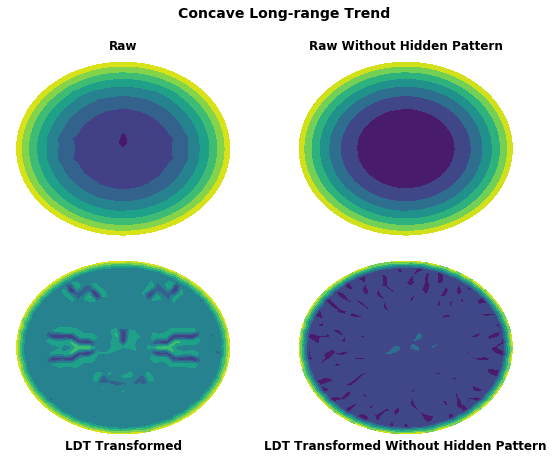

In [28]:
# Contour plots
fig3 = plt.figure(figsize=(8, 6))
fig3.suptitle('Concave Long-range Trend', fontsize=14, fontweight='bold', y=1.05)
ax9 = plt.subplot2grid((2, 2), (0, 0))
ax10 = plt.subplot2grid((2, 2), (0, 1))
ax11= plt.subplot2grid((2, 2), (1, 0))
ax12 = plt.subplot2grid((2, 2), (1, 1))

# rescale axes
for ax in fig3.axes:
    ax.set_xlim([-160, 160])
    ax.set_ylim([-160, 160])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set(frame_on=False)

ax9.set_title('Raw', fontweight='bold')
ax10.set_title('Raw Without Hidden Pattern', fontweight='bold')
ax11.set_title('LDT Transformed', fontweight='bold', y=-0.07)
ax12.set_title('LDT Transformed Without Hidden Pattern', fontweight='bold', y=-0.07)

ax9.tricontourf(data_concave.X, data_concave.Y, data_concave.Value)
ax10.tricontourf(data_concave_nohidden.X, data_concave_nohidden.Y, data_concave_nohidden.Value)
ax11.tricontourf(data_concave.X, data_concave.Y, data_concave.LDT)
ax12.tricontourf(data_concave_nohidden.X, data_concave_nohidden.Y, data_concave_nohidden.LDT)
plt.tight_layout()

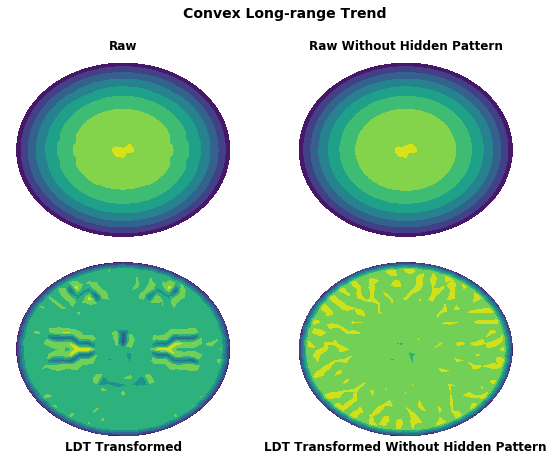

In [30]:
fig4 = plt.figure(figsize=(8, 6))
fig4.subplots_adjust(top=0.8)
fig4.suptitle('Convex Long-range Trend', fontsize=14, fontweight='bold', y=1.05)
ax13= plt.subplot2grid((2, 2), (0, 0))
ax14 = plt.subplot2grid((2, 2), (0, 1))
ax15= plt.subplot2grid((2, 2), (1, 0))
ax16 = plt.subplot2grid((2, 2), (1, 1))

# rescale axes
for ax in fig4.axes:
    ax.set_xlim([-160, 160])
    ax.set_ylim([-160, 160])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set(frame_on=False)

ax13.set_title('Raw', fontweight='bold')
ax14.set_title('Raw Without Hidden Pattern', fontweight='bold')
ax15.set_title('LDT Transformed', fontweight='bold', y=-0.07)
ax16.set_title('LDT Transformed Without Hidden Pattern', fontweight='bold', y=-0.07)  

ax13.tricontourf(data_convex.X, data_convex.Y, data_convex.Value)
ax14.tricontourf(data_convex_nohidden.X, data_convex_nohidden.Y, data_convex_nohidden.Value)
ax15.tricontourf(data_convex.X, data_convex.Y, data_convex.LDT)
ax16.tricontourf(data_convex_nohidden.X, data_convex_nohidden.Y, data_convex_nohidden.LDT)
plt.tight_layout()

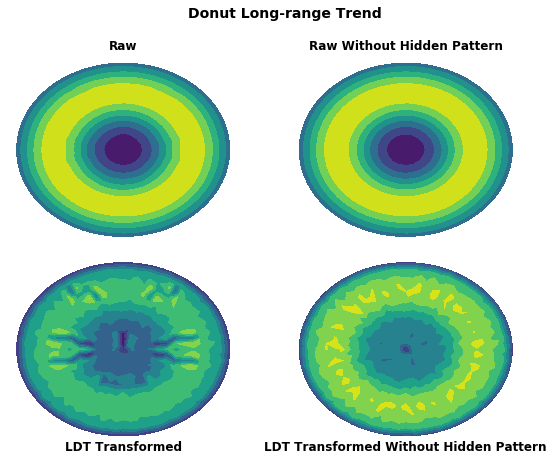

In [31]:
fig5 = plt.figure(figsize=(8, 6))
fig5.subplots_adjust(top=0.8)
fig5.suptitle('Donut Long-range Trend', fontsize=14, fontweight='bold', y=1.05)
ax17 = plt.subplot2grid((2, 2), (0, 0))
ax18 = plt.subplot2grid((2, 2), (0, 1))
ax19 = plt.subplot2grid((2, 2), (1, 0))
ax20 = plt.subplot2grid((2, 2), (1, 1))

# rescale axes
for ax in fig5.axes:
    ax.set_xlim([-160, 160])
    ax.set_ylim([-160, 160])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set(frame_on=False)


ax17.set_title('Raw', fontweight='bold')
ax18.set_title('Raw Without Hidden Pattern', fontweight='bold')
ax19.set_title('LDT Transformed', fontweight='bold', y=-0.07)
ax20.set_title('LDT Transformed Without Hidden Pattern', fontweight='bold', y=-0.07)
ax17.tricontourf(data_donut.X, data_donut.Y, data_donut.Value)
ax18.tricontourf(data_donut_nohidden.X, data_donut_nohidden.Y, data_donut_nohidden.Value)
ax19.tricontourf(data_donut.X, data_donut.Y, data_donut.LDT)
ax20.tricontourf(data_donut_nohidden.X, data_donut_nohidden.Y, data_donut_nohidden.LDT)
plt.tight_layout()

Looking at the LDT transforms of the data with hidden patterns (lower left-hand corner of each set of plots above) can you spot a pattern? 
  
Lets compare our trnaformed data with the raw hidden pattern used in the sample data.

C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previou

[None]

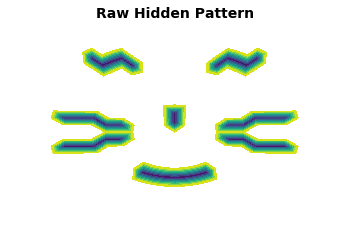

In [38]:
data_smiley_kitty = pd.read_csv('data/smiley_kitty.csv')
plt.tricontourf(data_smiley_kitty.X, data_smiley_kitty.Y, data_smiley_kitty.Value)
plt.title('Raw Hidden Pattern', fontsize=14, fontweight='bold');
plt.axes().get_xaxis().set_visible(False)
plt.axes().get_yaxis().set_visible(False)
plt.axes().set(frame_on=False)

Can you spot the hidden patterns in the countour plots above now? :)  
  
Two parameters can be used to fine tune the LDT transformation for various use cases: the neighborhood radius ($r\_local\ =\ R_{local}$) and the neighbor distance sensitivity ($dist\_sensitivity\ =\ p$,  the power parameter in Shepard's method for inverse distance wighting) found in the __*local_deviation_transform()*__ function. 
  
Large local neighborhood radius will result in stronger long-range influence on the transformed data. While large power parameter will reduce the relative importance of the more distant neighbors (all neighbors are treated equally when $dist\_sensitivity\ =\ 0$)  
  
Although LDT is quite effective at filtering random noise, transformations are not perfect. One of the limitations occurs when the range of the "long-range" effects is comparable to the LDT tranform $R_{local}$. In that case, the transformation cannot fully remove the "long-range" features (see remnants of the donut visible even on the LDT transformed data for the Donut pattern). Another effect is the non-uniformity of the sampling points mesh in the cartesian space that can result in artificial features most visible on LDT transforms of the Concave and Convex sets without hidden patterns.  
   
Despite these limitations, LDT is a highly effective technique that has demonstratedly been used to find hidden local patterns contributing as little as < 2% to the overall trends.

**References**:

[1] https://en.wikipedia.org/wiki/Inverse_distance_weighting